# Lab 9

In [2]:
from numpy import fft
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
from PIL import Image, ImageOps

## ANALIZA OBRAZÓW

In [3]:
def image_change(path, invert=True):
    img = Image.open(path) 
    gray = img.convert('L')
    if invert:
        gray = ImageOps.invert(gray)
    transformed = np.swapaxes(np.array(gray), 0, 1)
    return img, transformed

def plot_fig(img, title, size=(5,5)):
    # plt.figure(figsize=size)
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.show()


def detect_match(img_path, pattern_path, prob=0.95, invert=True, all=True):
    #Wczytanie i dokonanie odwrócenia kolorów
    img, img_transformed = image_change(img_path, invert)
    pat, pat_transformed = image_change(pattern_path, invert)

    #Transformacja
    img_fft = np.fft.fft2(img_transformed)
    img_fft_shift_abs = np.abs(img_fft)

    #Wykresy
    if all:
        plot_fig(np.swapaxes(np.log(img_fft_shift_abs),0,1), 'Moduł')
        plot_fig(np.swapaxes(np.angle(img_fft),0,1), 'Faza')
    plot_fig(np.swapaxes(pat_transformed,0,1), 'Wzór')
    plot_fig(np.swapaxes(img_transformed,0,1),'Obraz')

    C = np.real(np.fft.ifft2(np.multiply(img_fft, np.fft.fft2(np.rot90(pat_transformed, 2), s=img.size))))

    C_min = np.max(C) * prob
    args = np.argwhere(C >= C_min)  

    for x,y in args:
        for w in [0, pat.size[0]-1]:
            for z in range(pat.size[1]):
                img.putpixel((x-w, y-z), (255,0,0))
        for h in [0, pat.size[1]-1]:
            for z in range(pat.size[0]):
                img.putpixel((x-z, y-h), (255,0,0))

    plot_fig(img, 'Znalezione powtórzenia', size=(10,10) )


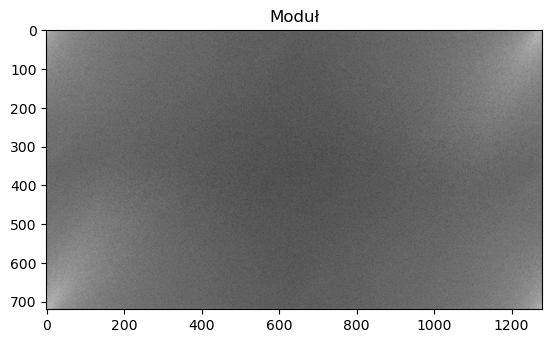

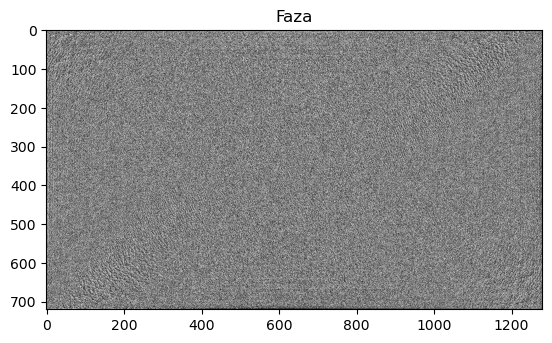

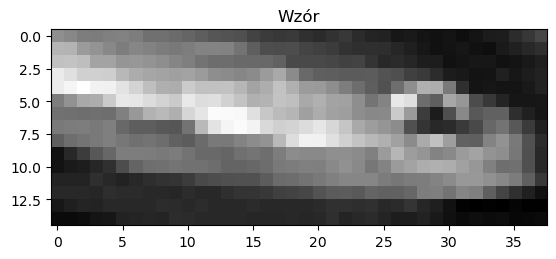

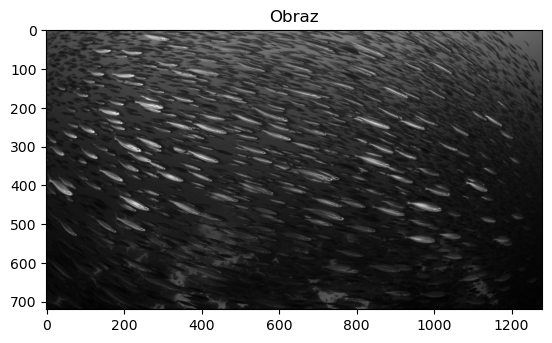

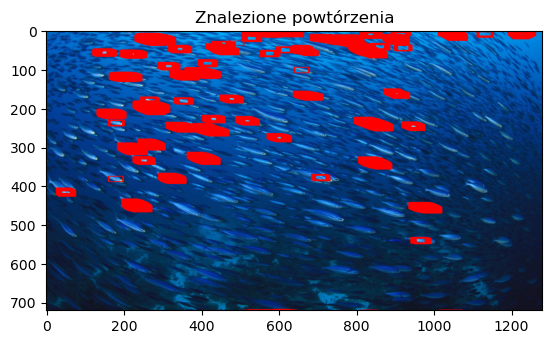

In [4]:
detect_match("school.jpg", "fish1.png", prob =0.65, invert=False)

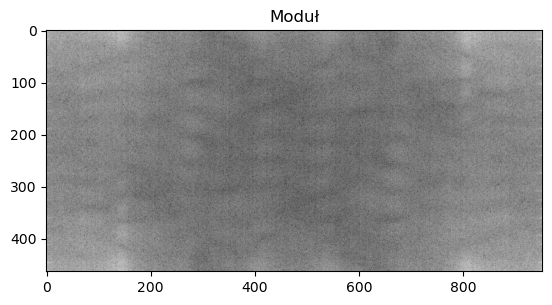

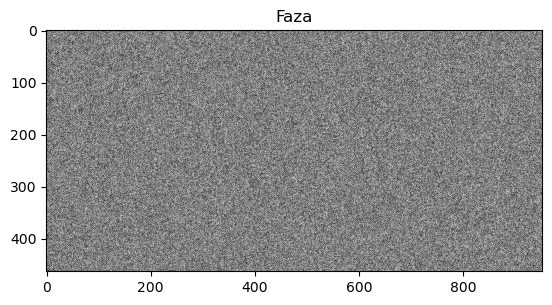

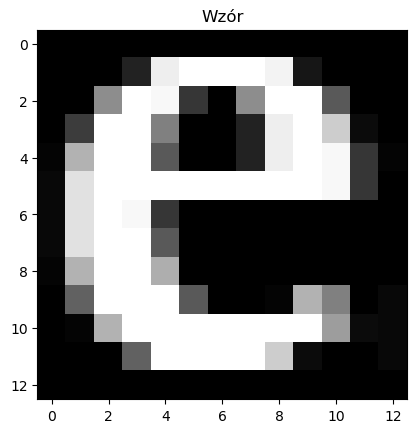

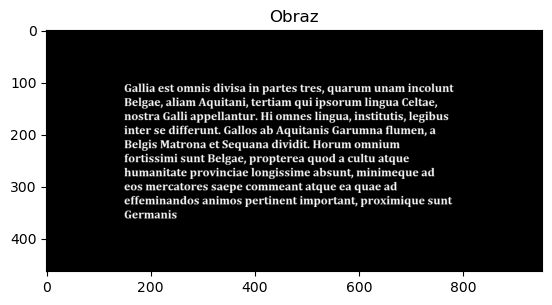

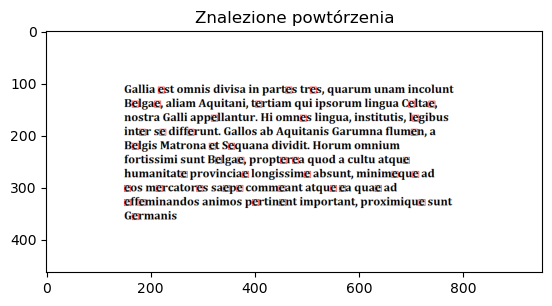

In [5]:
detect_match("galia.png", "galia_e.png")

## OCR

In [252]:
from PIL import Image, ImageDraw, ImageFont
import os
import pandas as pd
import cv2
import random
import numpy as np

In [227]:
def create_alphabet_images(font_file_path, output_folder, font_size=30):
    alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
    extra = ".,?!"
    font = ImageFont.truetype(font_file_path, font_size)

    for letter in alphabet+extra:
        letter = letter.lower()
        image = Image.new("RGB", (font_size,int(font_size*3)), color="white")
        draw = ImageDraw.Draw(image)
        draw.text((0, 0), letter, font=font, fill="black")

        if letter in ["m", "w"]:
            a = 2
        elif letter in ["i", "j", "!", ".", ",", "l", "f", "r"]:
            a=19
        else:
            a=11

        image_with_whitespace = Image.new("RGB", (font_size-a, font_size+7), color="white")
        image_with_whitespace.paste(image, (1, 0))

        if letter in extra:
            image_with_whitespace.save(f"{output_folder}/e{extra.index(letter)}.png")
        else:
            image_with_whitespace.save(f"{output_folder}/{letter}.png")

In [256]:
def create_text_images(text,font_file_path, output_folder, font_size=30, wide=20):
    text = text.lower() 

    font = ImageFont.truetype(font_file_path, font_size)

    image = Image.new("RGB", (font_size*50,int(font_size*3)*wide), color="white")
    draw = ImageDraw.Draw(image)
    draw.text((10, 10), text, font=font, fill="black", spacing=50)

    image_with_whitespace = Image.new("RGB", (font_size*50, font_size*wide), color="white")
    image_with_whitespace.paste(image, (1, 1))

    image_with_whitespace.save(f"{output_folder}.png")

def rotate_text_image_randomly(image_path, output_path):
    image = Image.open(image_path)
    angle = random.uniform(-45, 45)
    rotated_image = image.rotate(angle, expand=True, fillcolor='white')
    rotated_image.save(output_path)

In [257]:
create_alphabet_images("./fonts/Lato-Black.ttf", "./letters/lato")
create_alphabet_images("./fonts/Alice-Regular.ttf", "./letters/alice")

In [258]:
O = "okljphdimneabhucqgrsft0yvw1xz89234567.,!?"

def create_list_order(Ord, font):
    new = []
    extra = ".,?!"
    for ch in Ord:
        if ch in extra:
            new.append(f"./letters/{font}/e{extra.index(ch)}.png")
        else:
            new.append(f"./letters/{font}/{ch.upper()}.png")
    return new

ORDER_LATO = create_list_order(O, "lato")
ORDER_ALICE = create_list_order(O, "alice")

In [312]:
def detect_rotation_angle(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=100, maxLineGap=10)
    angle = 0
    if lines is not None:
        angles = []
        for line in lines:
            x1, y1, x2, y2 = line[0]
            angle = np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi
            angles.append(angle)
        angle = np.mean(angles)

    return angle

def straighten_image(image_path):
    angle = detect_rotation_angle(image_path)
    image = Image.open(image_path)
    rotated_image = image.rotate(-angle, expand=True, fillcolor='white')
    return rotated_image

def svd_f(image):
    U, S, Vt = np.linalg.svd(image, full_matrices=False)
    k = 500
    S = np.diag(S[:k])
    U = U[:, :k]
    Vt = Vt[:k, :]
    denoised_image = np.dot(U, np.dot(S, Vt))
    return np.clip(denoised_image, 0, 255).astype(np.uint8)

def image_change(path, invert=True, rotate=True, svd_b=False):
    if rotate:
        img = straighten_image(path)
        plot_fig(img, title="Po obróceniu")
    else:
        img = Image.open(path)

    
    if svd_b:
        img_np = np.array(img.convert('L'))
        img = Image.fromarray(svd_f(img_np))
    
    gray = img.convert('L')
    
    if invert:
        gray = ImageOps.invert(gray)
    
    transformed = np.swapaxes(np.array(gray), 0, 1)
    
    return img, transformed

In [320]:
def search_next(x,y,dic, radius=10):
    x = x-radius+1
    y = y-radius+1
    for r1 in range(0,2*radius):
        for r2 in range(0,2*radius):
            if dic.get((x+r1, y+r2)) != None:
                return False
    return True


def overlapping(x,y,pat,s):
    w=pat.size[0]//2
    h = pat.size[1]//2
    if (x-w, y-h) in s:
            return False
    return True


def match(img, img_transformed, pattern_path,set_k, prob=0.999, dic={}, svd=False):
    if pattern_path.split("/")[-1] in ["e0.png", "H.png", "e3.png", "e2.png", "e1.png"]:
        prob = 0.995
    if pattern_path.split("/")[-1] in ["I.png", "C.png"]:
        prob = 0.93
    if pattern_path.split("/")[-1] in ["L.png", "N.png"]:
        prob = 0.99

    pat, pat_transformed = image_change(pattern_path, rotate=False)
    img_fft = np.fft.fft2(img_transformed)
    img_fft_shift_abs = np.abs(img_fft)
    C = np.real(np.fft.ifft2(np.multiply(img_fft, np.fft.fft2(np.rot90(pat_transformed, 2), s=img.size))))
    C_min = np.max(C) * prob
    args = np.argwhere(C >= C_min)

    extra = ".,?!"
    count = 0
        
    for x,y in args:
        # if search_next(x,y,dic):
        if overlapping(x,y,pat,set_k):
            count += 1
            name = pattern_path.split("/")[-1].split(".")[0]
            new_cor = (x-pat.size[0]+1, y-pat.size[1]+1)
            if len(name) > 1:
                dic[(x,y)] = (extra[int(name[-1])].lower(), new_cor)
            else:
                dic[(x,y)] = (name.lower(), new_cor)
            for w in [0, pat.size[0]-1]:
                for z in range(pat.size[1]):
                    img.putpixel((x-w, y-z), (255,0,0))
            for h in [0, pat.size[1]-1]:
                for z in range(pat.size[0]):
                    img.putpixel((x-z, y-h), (255,0,0))
            for w in range(pat.size[0]):
                for h in range(pat.size[1]):
                    set_k.add((x-w, y-h))

    return dic, img, set_k, count


def white_spaces(t1, s1,s2,space_len=3, new_line=25):
    r1 = t1[0] - s2[0]
    r2 = s1[0] - s2[0]
    if r1 > space_len:
        return " "
    elif r2 < - new_line:
        return "\n"
    return ""

#Wyprostuj tekst
    

def read_text(text_path,ORDER, svd_bool=False):
    char_count = {}
    dic = {}
    set_ = set()
    img, img_transformed = image_change(f"./text/{text_path}.png", svd_b=svd_bool)
    for plik in ORDER:
        # dic, img, set_, c = match(f"./text/{text_path}.png",plik,set_k=set_, dic=dic, )
        dic, img, set_, c = match(img, img_transformed,plik,set_k=set_, dic=dic)
        char_count[plik.split("/")[-1]]=c
    keys = sorted(dic.keys(), key=lambda x: (x[1],x[0]))
    string = ""
    for key_id in range(len(keys)):
        if key_id != 0:
            # print(dic[keys[key_id]][1], keys[key_id-1])
            string = string + white_spaces(dic[keys[key_id]][1],keys[key_id], keys[key_id-1])
        string += dic[keys[key_id]][0]
    plot_fig(img, title="Zdanie")

    return string, char_count

def create_dic(text):
    dic={}
    for char in text:
        if dic.get(char) == None:
            dic[char] = 1
        else:
            dic[char] += 1
    return dic

def check(wanted, got):
    all = max(len(wanted), len(got))
    sum = 0
    dic_wanted = create_dic(wanted)
    dic_got = create_dic(got)
    for key in dic_wanted.keys():
        g = dic_got.get(key)
        w = dic_wanted.get(key)
        if g is not None:
            sum += min(w,g)
    return sum/all * 100


def create_and_check(text,font='Lato-Black', order=ORDER_LATO, svd_b=False,rotate=False):
    create_text_images(text,f"./fonts/{font}.ttf", f"./text/{text[0:5]}")
    if rotate:
        rotate_text_image_randomly(f"./text/{text[0:5]}.png", f"./text/{text[0:5]}.png")
    string, char_count = read_text(f"{text[0:5]}", order, svd_b)
    text = text.lower()
    print("Chcemy:")
    print(text)
    print("\n")
    print("Dostajemy:")
    print(string)
    print("\n")
    checked = check(text, string)
    return f"Poprawność: {round(checked,2)}%", checked


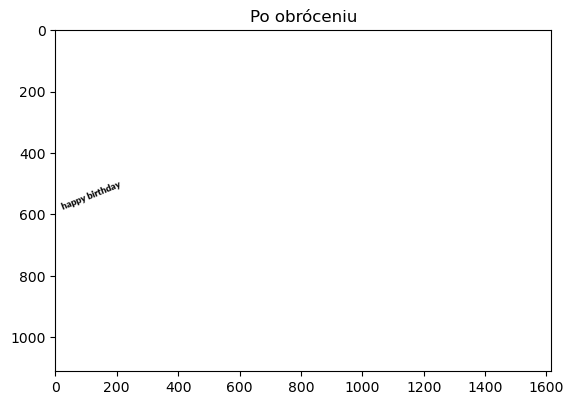

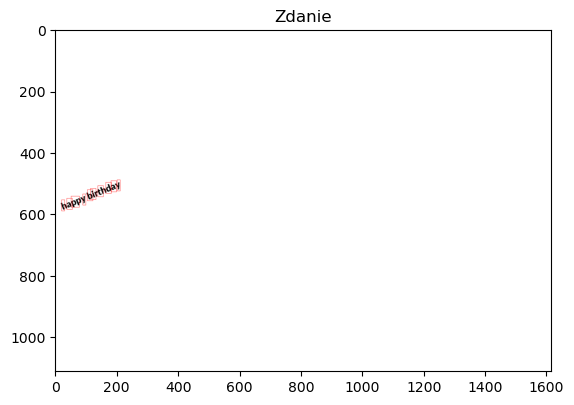

Chcemy:
happy birthday


Dostajemy:
jzo
0kplmar




('Poprawność: 21.43%', 21.428571428571427)

In [319]:
create_and_check("Happy Birthday")

## Czcionka bezszeryfowa - Lato-Black

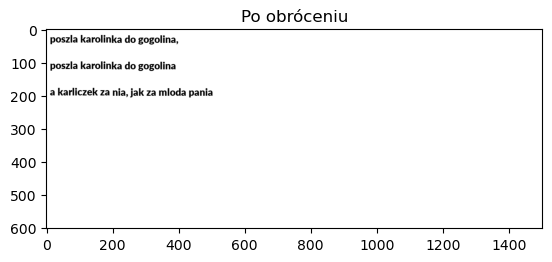

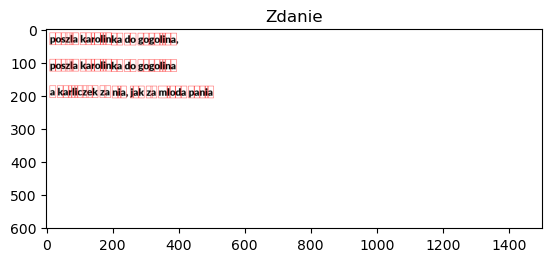

Chcemy:
poszla karolinka do gogolina,
poszla karolinka do gogolina
a karliczek za nia, jak za mloda pania


Dostajemy:
poszla karolinka do gogolina
poszla karolinka do gogolina
a karliczek za nia jak za mloda pania


Poprawność: 97.94%


In [321]:
string, check_1 = create_and_check("Poszla karolinka do gogolina,\nposzla karolinka do gogolina\na Karliczek za nia, jak za mloda pania")
print(string)

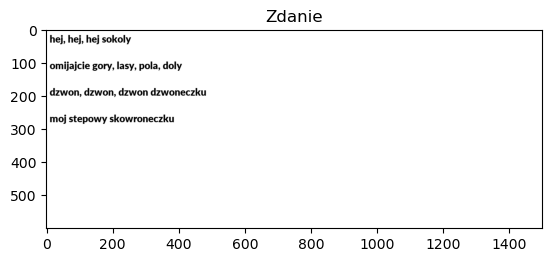

Chcemy:
hej, hej, hej sokoly
omijajcie gory, lasy, pola, doly
dzwon, dzwon, dzwon dzwoneczku
moj stepowy skowroneczku


Dostajemy:
l ej l ej l ej sokoly
omijajcie gory lasy pola doly
dzwon dzwon dzwon dzwoneczku
moj stepowy skowroneczku


Poprawność: 90.83%


In [290]:
string, check_2 = create_and_check("hej, hej, hej sokoly\nomijajcie gory, lasy, pola, doly\ndzwon, dzwon, dzwon dzwoneczku\nmoj stepowy skowroneczku")
print(string)

In [291]:
string, check_3 = create_and_check("Lorem ipsum dolor sit amet, consectetur adipiscing elit,\nsed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam,\nquis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat.\nDuis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur.\nExcepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.")
print(string)

KeyboardInterrupt: 

## Czcionka szeryfowa - Alice-Regular

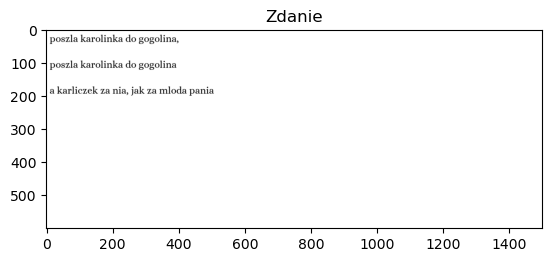

Chcemy:
poszla karolinka do gogolina,
poszla karolinka do gogolina
a karliczek za nia, jak za mloda pania


Dostajemy:
poszla karolinka do gogolina
poszla karolinka do gogolina
a karliczek za nia jak za mloda pania


Poprawność: 97.94%


In [ ]:
string, check_4 = create_and_check("poszla karolinka do gogolina,\nposzla karolinka do gogolina\na Karliczek za nia, jak za mloda pania", font = 'Alice-Regular', order=ORDER_ALICE)
print(string)

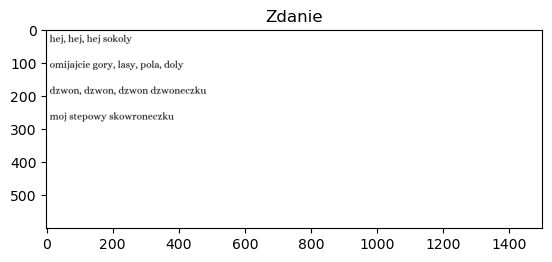

Chcemy:
hej, hej, hej sokoly
omijajcie gory, lasy, pola, doly
dzwon, dzwon, dzwon dzwoneczku
moj stepowy skowroneczku


Dostajemy:
l ej l ej l ej sokoly
omijajcie gory lasy pola doly
dzwon dzwon dzwon dzwoneczku
moj stepowy skowroneczku


Poprawność: 90.83%


In [ ]:
string, check_5 = create_and_check("hej, hej, hej sokoly\nomijajcie gory, lasy, pola, doly\ndzwon, dzwon, dzwon dzwoneczku\nmoj stepowy skowroneczku", font = 'Alice-Regular', order=ORDER_ALICE)
print(string)

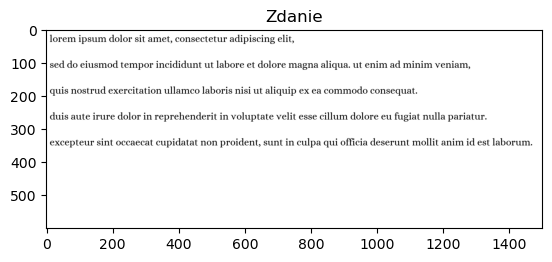

Chcemy:
lorem ipsum dolor sit amet, consectetur adipiscing elit,
sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. ut enim ad minim veniam,
quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat.
duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur.
excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.


Dostajemy:
lorem ipsum dolor sitamet consectetur adipiscing elit
sed do eiusmod tempor incididuntutlabore etdolore magna alicua utenim ad minim yeniam
cuisnostrud exercitation ullamco laborisnisi utalicuip ex ea commodo consecuat
duisaute irure dolor in reprel en k ritin yoluptate yelitesse cillum dolore eu fugiatnulla pariatur
excepteur sintoccaecatcupidatatnon proi k nt suntin culpa cui officia k seruntmollitanim id estlaborum


Poprawność: 91.91%


In [ ]:
string, check_6 = create_and_check("Lorem ipsum dolor sit amet, consectetur adipiscing elit,\nsed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam,\nquis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat.\nDuis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur.\nExcepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.",font = 'Alice-Regular', order=ORDER_ALICE)
print(string)

# Porównanie

In [ ]:
dataset = pd.DataFrame()
dataset["Bezszeryfowa"] = [check_1, check_2, check_3]
dataset["Szeryfowa"] = [check_4, check_5, check_6]
dataset.index = ["Karolinka", "Sokoły", "Lorem ipsum"]
print(dataset)


             Bezszeryfowa  Szeryfowa
Karolinka       97.938144  97.938144
Sokoły          90.825688  90.825688
Lorem ipsum     93.258427  91.910112
